## Problem

Everyone is finally exhausted and ready to go, when suddenly Dr. Dwight appears in front of your group and tells you that he has found some interesting amino acid combinations in the protein translations of the DNA sample collected from the Aveosaur bone. He has one final task for you but it is a simple computational task that can be solved on your laptop in the cruise while you are on your way to Galapagos. You listen as he closely explains the final puzzle of the most interesting day you had in your life:

There is a central C atom and 4 amino acids bound to it in one of the proteins (as shown below). You must write a program that outputs the positions (in a 3D space) of the Amino acids with the C on the origin.

```
    Ai
Aj  C  Ak
    Al
```

You are given the following information:

Charges on the amino acid.

| Amino Acid | Charge |
| ---------- | ------ |
| A1         | 0.848  |
| A2         | 0.975  |
| A3         | 1.185  |
| A4         | 0.848  |
| A5         | 1.133  |
| A6         | 1.137  |

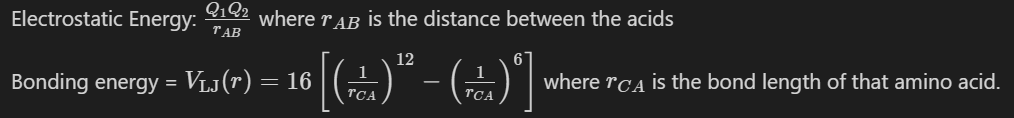

### Input
The four amino acids

## Output
The positions of the amino acids

## Solution

The idea is to calculate the total energy of all interactions given the amino acids and then somehow try to minimize the energy.  
A simple way to minimize the energy would be to just calculate the minimal values (by taking differentials), another method of approximation would be to use gradient descent to find the minimal point after a few iterations. We will be implementing the latter solution.

The first step would be to write functions for the equations above.

In [1]:
from math import sqrt
import numpy as np

In [2]:
alpha = 0.5
acid_charge = {1: 0.848, 2: 0.975, 3: 1.185, 4: 0.848, 5: 1.133, 6: 1.137}

In [3]:
# Function to calculate Euclidean distance between 2 points
def euclidean_distance(loc1, loc2):
    dist = sqrt((loc1[0] - loc2[0]) ** 2 + (loc1[1] - loc2[2]) ** 2 + (loc1[2] - loc2[2]) ** 2)
    return dist

In [4]:
# Function to calculate electrostatic energy
def electrostatic_energy(charge1, charge2, distance):
    if distance != 0:
        return (charge1 * charge2)/float(distance)
    else:
        return float('inf')

In [5]:
# Function to calculate the bonding energy
def bonding_energy(bond_distance):
    if bond_distance != 0:
        return 16 * ((1 / bond_distance) ** 12 - (1 / bond_distance) ** 6)
    else:
        return float('inf')

In [6]:
# Function to calculate the derivative of electrostatic energy
def dist_ee_deriv(energy, charge1, charge2, distance):
    if distance != 0:
        return -1 * alpha * energy * ((charge1 * charge2) / (distance) ** 2)
    else:
        return float('inf')

In [7]:
# Function to calculate the derivative of bonding energy
def dist_be_deriv(energy, bond_distance):
    if bond_distance != 0:
        return alpha * energy * ((2 * ((1 / bond_distance) ** 11)) - ((1 / bond_distance) ** 5))
    else:
        return float('inf')

In [8]:
#Function to calculate derivative w.r.t. coordinates
def coord_ee_deriv(prev_deriv, loc1, loc2, index, sign):
    return sign * prev_deriv * (((loc1[0] - loc2[0]) ** 2 + (loc1[1] - loc2[2]) ** 2 + (loc1[2] - loc2[2]) ** 2) ** -0.5) * (loc1[index] - loc2[index])

In [9]:
# Function to calculate energy
def calculate_energy(amino_acids, coordinates):
    energy = 0
    for acid1 in amino_acids:
        for acid2 in amino_acids:
            if acid1 < acid2:
                distance = euclidean_distance(coordinates[acid1], coordinates[acid2])
                energy += electrostatic_energy(acid_charge[acid1], acid_charge[acid2], distance)
        bonding_distance = euclidean_distance(coordinates[acid1], [0, 0, 0])
        energy += bonding_energy(bonding_distance)
    return energy

In [10]:
def update_coordinates(energy, amino_acids, coordinates):
    new_coords = coordinates.copy()
    for acid1 in amino_acids:
        for acid2 in amino_acids:
            if acid1 < acid2:
                distance = euclidean_distance(coordinates[acid1], coordinates[acid2])
                ee_deriv = dist_ee_deriv(energy, acid_charge[acid1], acid_charge[acid2], distance)
                new_coords[acid1][0] -= coord_ee_deriv(ee_deriv, coordinates[acid1], coordinates[acid2], 0, 1)
                new_coords[acid1][1] -= coord_ee_deriv(ee_deriv, coordinates[acid1], coordinates[acid2], 1, 1)
                new_coords[acid1][2] -= coord_ee_deriv(ee_deriv, coordinates[acid1], coordinates[acid2], 2, 1)
                new_coords[acid2][0] -= coord_ee_deriv(ee_deriv, coordinates[acid1], coordinates[acid2], 0, -1)
                new_coords[acid2][1] -= coord_ee_deriv(ee_deriv, coordinates[acid1], coordinates[acid2], 1, -1)
                new_coords[acid2][2] -= coord_ee_deriv(ee_deriv, coordinates[acid1], coordinates[acid2], 2, -1)
        bonding_distance = euclidean_distance(coordinates[acid1], [0, 0, 0])
        be_deriv = dist_be_deriv(energy, bonding_distance)
        new_coords[acid1][0] -= coord_ee_deriv(be_deriv, coordinates[acid1], [0, 0, 0], 0, 1)
        new_coords[acid1][1] -= coord_ee_deriv(be_deriv, coordinates[acid1], [0, 0, 0], 1, 1)
        new_coords[acid1][2] -= coord_ee_deriv(be_deriv, coordinates[acid1], [0, 0, 0], 2, 1)
    return new_coords

In [11]:
def optimize(amino_acids, epochs):
    amino_acids = sorted(amino_acids)
    # Initialize positions
    coordinates = {}
    for acid in amino_acids:
        coordinates[acid] = [np.random.uniform(0.0, 10.0), np.random.uniform(0.0, 10.0), np.random.uniform(0.0, 10.0)]
    for i in range(epochs):
        print("Epoch #", i)
        print("Coordinates: ", coordinates)
        energy = calculate_energy(amino_acids, coordinates)
        new_coordinates = update_coordinates(energy, amino_acids, coordinates)
        coordinates = new_coordinates
        print("Energy: ", energy)
        print()
        print()
    print("Final coordinates: ", coordinates)
    print("Final Energy: ", energy)

In [12]:
optimize([1, 2, 3, 4], 1000)

Epoch # 0
Coordinates:  {1: [7.454386064718069, 2.4520448329111453, 8.910070937615304], 2: [4.994824405688428, 8.588624187519788, 0.16692351868621835], 3: [1.8021431963425938, 0.6902805282254976, 7.067574110108512], 4: [2.696221191287286, 8.198013901696568, 3.6894081914265673]}
Energy:  0.817185174868915


Epoch # 1
Coordinates:  {1: [7.464618940013646, 2.4466518492484037, 8.919590024075863], 2: [4.999916354077927, 8.59963242835092, 0.15195997799064836], 3: [1.7897342841229558, 0.6492005001301602, 7.086855056755152], 4: [2.693301023411762, 8.233406379768544, 3.675571309681301]}
Energy:  0.8128817580058145


Epoch # 2
Coordinates:  {1: [7.474721810541426, 2.441329466489792, 8.928985511867847], 2: [5.00494146924295, 8.610475079327513, 0.13720051722359763], 3: [1.7775256532494543, 0.6089442752167704, 7.105747068952884], 4: [2.690377844584585, 8.268074274617694, 3.6620439312340687]}
Energy:  0.8087062315877055


Epoch # 3
Coordinates:  {1: [7.484698975165785, 2.436075232868686, 8.938261556

Coordinates:  {1: [8.402812885397381, 1.9537910587559564, 9.785132949408073], 2: [5.465830648923925, 9.521239553797075, -1.180058717482405], 3: [0.7529963710787172, -2.46424382440069, 8.536286284124737], 4: [2.3260477663059596, 10.916315071409736, 2.693772892040486]}
Energy:  0.5764647676233551


Epoch # 158
Coordinates:  {1: [8.406879404208995, 1.9516459561307617, 9.788864069120837], 2: [5.467869627889765, 9.524926275983042, -1.1857201737381768], 3: [0.7487541447617145, -2.47629187968588, 8.541843527271219], 4: [2.32418547530605, 10.926820129210721, 2.6901510998704254]}
Energy:  0.5758005262402716


Epoch # 159
Coordinates:  {1: [8.410932830453154, 1.949507629147369, 9.792583048153848], 2: [5.469902338849897, 9.528598877087125, -1.191362775039121], 3: [0.7445269365957455, -2.488294298916493, 8.547379330697613], 4: [2.322327523449986, 10.937286916800506, 2.686544005165902]}
Energy:  0.575140221447818


Epoch # 160
Coordinates:  {1: [8.414973265612652, 1.9473760253477757, 9.796289981169

Energy:  0.5065535384365399


Epoch # 306
Coordinates:  {1: [8.902520400808637, 1.6891868255892921, 10.242739283764735], 2: [5.718902756633406, 9.958225851019279, -1.8717906059899532], 3: [0.24051572077450967, -3.902206202991393, 9.19687403787385], 4: [2.0858669463140695, 12.181813907519404, 2.267851377807991]}
Energy:  0.5062112026095796


Epoch # 307
Coordinates:  {1: [8.905336014034257, 1.6876901717586712, 10.245312957178387], 2: [5.72034446619222, 9.960600800051024, -1.875669269613863], 3: [0.23767173404355244, -3.910107475384943, 9.20048936711884], 4: [2.084454259755451, 12.188836792438767, 2.265543598905683]}
Energy:  0.5058700459153319


Epoch # 308
Coordinates:  {1: [8.908146210142357, 1.6861963348483178, 10.247881629162316], 2: [5.7217835916655915, 9.962970247868824, -1.8795402958862673], 3: [0.23483364251408906, -3.917991686564152, 9.20409673769265], 4: [2.0830436777704153, 12.195845303609701, 2.263241132730771]}
Energy:  0.5055300609968542


Epoch # 309
Coordinates:  {1: [8.

Coordinates:  {1: [9.318781844363738, 1.4672663157443533, 10.622705692740253], 2: [5.934201666944398, 10.29948797645298, -2.4435563932043434], 3: [-0.1757432289251302, -5.052497991060599, 9.721638677410642], 4: [1.8706598487964796, 13.212777173259784, 1.9352132522066157]}
Energy:  0.4607717017141848


Epoch # 477
Coordinates:  {1: [9.320930887826988, 1.4661173403662981, 10.624664668655017], 2: [5.935324889531375, 10.301199739936253, -2.446500774953411], 3: [-0.17787225935878853, -5.058354517655261, 9.724302557290594], 4: [1.8695170922971014, 13.218071093254478, 1.9335362210527993]}
Energy:  0.46056036566605535


Epoch # 478
Coordinates:  {1: [9.323077086786618, 1.464969854161996, 10.626621024621853], 2: [5.936446749257411, 10.302908737225945, -2.4494411935989504], 3: [-0.1799982844270854, -5.064202550539858, 9.726962496005298], 4: [1.8683755370947315, 13.223357797263434, 1.931861783707323]}
Energy:  0.4603495217156968


Epoch # 479
Coordinates:  {1: [9.325220450192658, 1.46382385250101

Coordinates:  {1: [9.647466397059937, 1.2911862625869017, 10.922008659351464], 2: [6.107463738914629, 10.555562267748009, -2.893197582747571], 3: [-0.4993149216370461, -5.940294397634521, 10.124583591243407], 4: [1.6923574804532933, 14.020616599851909, 1.6828025226474197]}
Energy:  0.43073270923186224


Epoch # 646
Coordinates:  {1: [9.649234294838802, 1.2902373714242976, 10.92361683717402], 2: [6.108403821952535, 10.55690891357882, -2.8956127490322907], 3: [-0.5010448048893843, -5.945030004760411, 10.126728294007318], 4: [1.6913797696493242, 14.024954697005711, 1.681465738162169]}
Energy:  0.43058261492337147


Epoch # 647
Coordinates:  {1: [9.65100040396917, 1.289289422065325, 10.925223370038708], 2: [6.109343042502096, 10.558253873844883, -2.8980254404356067], 3: [-0.5027728321453405, -5.949760432775267, 10.12887060266898], 4: [1.6904028535597537, 14.029288358963584, 1.6801305156949913]}
Energy:  0.43043278562635456


Epoch # 648
Coordinates:  {1: [9.652764728743165, 1.2883424122790

Coordinates:  {1: [9.920748996241082, 1.1443001742198422, 11.170389298262448], 2: [6.25384827053048, 10.759927435319922, -3.266196992315826], 3: [-0.7655177487730975, -6.668002272546004, 10.453590062264427], 4: [1.538952566095945, 14.690887422407197, 1.4785449907673944]}
Energy:  0.40879783157635136


Epoch # 813
Coordinates:  {1: [9.922267439626768, 1.1434829318534216, 11.171768186178209], 2: [6.254667689143507, 10.761041802736717, -3.268267776256587], 3: [-0.7669903781463582, -6.67202284579738, 10.455404695474458], 4: [1.538087661296036, 14.694611124743927, 1.4774229056713948]}
Energy:  0.40868265984896984


Epoch # 814
Coordinates:  {1: [9.923784636016642, 1.1426663491999354, 11.173145928555117], 2: [6.255486502405204, 10.76215502388169, -3.270336842594935], 3: [-0.7684617297180355, -6.676039881422897, 10.457217698109632], 4: [1.5372233307491097, 14.698331776001627, 1.476301877819953]}
Energy:  0.4085676523347711


Epoch # 815
Coordinates:  {1: [9.925300587836075, 1.1418504249933008

Energy:  0.3987387358944578


Epoch # 906
Coordinates:  {1: [10.058336017691914, 1.0702042405212335, 11.29527766063184], 2: [6.328372207017106, 10.859965649577484, -3.453766298130265], 3: [-0.8986809042090341, -7.031378511648784, 10.617458644893357], 4: [1.4600343733324554, 15.028345153276392, 1.3774135650263235]}
Energy:  0.39863721151125436


Epoch # 907
Coordinates:  {1: [10.05974693245946, 1.0694439497991097, 11.296557794243766], 2: [6.329139331772202, 10.860981758717388, -3.455689115950002], 3: [-0.9000436550058494, -7.035095377707164, 10.619133387065657], 4: [1.4592193872537282, 15.031806451938538, 1.376382054460025]}
Energy:  0.39853581788389036


Epoch # 908
Coordinates:  {1: [10.061156799368366, 1.068684214726534, 11.297836965763596], 2: [6.329905945935737, 10.861996916302166, -3.4576104932710767], 3: [-0.9014053381194601, -7.0388092975320795, 10.620806773131644], 4: [1.458404891697065, 15.035265200222089, 1.3753514206187023]}
Energy:  0.39843455470835354


Epoch # 909
Coordin